- 1. The authors mention that they do poly-A selection of the RNA samples (p.6). What proportion of
transcripts identified are actually unspliced? Given that more than 50% of the identified A-to- I edits are in the
introns, the data sets examined may actually be an under representation of the true unspliced
transcriptome. 
    - get the introns where each editing site occurs
    - count reads supporting splicing versus reads supporting splicing versus retained intron
    - calculate the difference between intron and exon reads

# Minor point 1
### Check why there are so many intronic editing sites:
- Check intron retention between introns that were edited versus a background (all introns that were spliced)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob

rnaseq_dir = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6/'
editing_calls_dir = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editing_calls_v15_final'
wd = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editor_response_minor_1/ws254/'

In [2]:
x = os.path.join(wd, 'supplemental_doc_1.txt')
! ls $x

/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editor_response_minor_1/ws254/supplemental_doc_1.txt


# Look at inclusion in all introns found

In [3]:
# first find the sj out files
SJOuts = glob.glob(os.path.join(rnaseq_dir,"*.rmRep.bamSJ.out.tab"))
SJOuts

['/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6/GSF973-Hundley-SarahD-1_S1_R1_001.polyATrim.adapterTrim.rmRep.bamSJ.out.tab',
 '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6/GSF973-Hundley-SarahD-6_S6_R1_001.polyATrim.adapterTrim.rmRep.bamSJ.out.tab',
 '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6/GSF973-Hundley-SarahD-2_S2_R1_001.polyATrim.adapterTrim.rmRep.bamSJ.out.tab',
 '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6/GSF973-Hundley-SarahD-5_S5_R1_001.polyATrim.adapterTrim.rmRep.bamSJ.out.tab',
 '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6/GSF973-Hundley-SarahD-7_S7_R1_001.polyATrim.adapterTrim.rmRep.bamSJ.out.tab',
 '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6/GSF973-Hundley-SarahD-4_S4_R1_001.polyATrim.adapterTrim.rmRep.bamSJ.out.tab',
 '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6/GSF973-Hundley-SarahD-3_S3_R1_001.polyATrim.adapt

In [4]:
wt1 = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6/GSF973-Hundley-SarahD-1_S1_R1_001.polyATrim.adapterTrim.rmRep.bamSJ.out.tab'
wt3 = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6/GSF973-Hundley-SarahD-3_S3_R1_001.polyATrim.adapterTrim.rmRep.bamSJ.out.tab'
wt6 = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6/GSF973-Hundley-SarahD-6_S6_R1_001.polyATrim.adapterTrim.rmRep.bamSJ.out.tab'

sjout_names = ['chrom','start','end','n_strand','motif','annotated','unique','multi','max_spliced_overhang']

def strand(row):
    """
    Converts numeric strand info to canonical.
    """
    if row['n_strand'] == 0:
        return 'x'
    elif row['n_strand'] == 1:
        return '+'
    elif row['n_strand'] == 2:
        return '-'
    else:
        return 'x'
        
def read(fn):
    """
    Read in sj.out.tab file, return just introns whose strand is 
    determined and who has at least 10 reads supporting it.
    """
    df = pd.read_table(fn, names=sjout_names)
    df['strand'] = df.apply(strand, axis=1)
    df['start'] = df['start'] - 1 # turn one based start into 0 based 
    print('number of introns with undefined strand (discarding): ', df[df['strand']=='x'].shape)
    df = df[df['unique']>=10]
    df = df[df['strand']!='x']
    return df

wts = [wt1, wt3, wt6]


wt1_df = read(wts[0])
print("Number of introns discovered in WT1 sample: ", wt1_df.shape)
wt3_df = read(wts[1])
print("Number of introns discovered in WT3 sample: ", wt3_df.shape)
wt6_df = read(wts[2])
print("Number of introns discovered in WT6 sample: ", wt6_df.shape)

# merge all and drop duplicates, returning the set of all introns in the combined WT sample.
merged = pd.concat([wt1_df, wt3_df, wt6_df], axis=0).drop_duplicates(['chrom','start','end','strand'])
print("Number of introns discovered in WT sample: ", merged.shape)

('number of introns with undefined strand (discarding): ', (253, 10))
('Number of introns discovered in WT1 sample: ', (63091, 10))
('number of introns with undefined strand (discarding): ', (209, 10))
('Number of introns discovered in WT3 sample: ', (63681, 10))
('number of introns with undefined strand (discarding): ', (132, 10))
('Number of introns discovered in WT6 sample: ', (63328, 10))
('Number of introns discovered in WT sample: ', (75965, 10))


In [5]:
# Save all background introns as a bedfile (tabbed)
out_bed = os.path.join(wd,'WT.introns.bed')
merged[['chrom','start','end','annotated','unique','strand']].to_csv(
    out_bed, sep='\t', header=False, index=False
)

# Run junction counter to count number of reads supporting splicing/intron retention for all discovered introns
- https://github.com/byee4/junction-counter

In [6]:
junc = '/home/bay001/projects/codebase/junction-counter/junction_counter/count_junctions.py'
bam = os.path.join(editing_calls_dir,'WT.sorted.rmdup.readfiltered.bam')
outfile = os.path.join(wd,'WT.jxc')

In [7]:
cmd = 'python {} '.format(junc)
cmd = cmd + '--bed {} '.format(out_bed)
cmd = cmd + '--bam {} '.format(bam)
cmd = cmd + '--min_overlap {} '.format(10)
cmd = cmd + '--library {} '.format('reverse_se')
cmd = cmd + '--outfile {}'.format(outfile)
! $cmd

100%|####################################9| 75955/75965 [10:29<00:00, 85.36it/s]

# Run junction counter to count number of reads supporting splicing/intron retention for edited introns

In [8]:
editing_sites = pd.read_table(
    os.path.join(wd, 'annotations_wbgene.txt'),
) # this comes from the 'final analysis notebook'
editing_sites.head()

,chrom,pos-1,pos,approx_edit_fraction,approx_coverage,strand,region_chrom,source,region_start,region_end,region_strand,attributes,region,id,wbgene,gene
0,chrI,3033978,3033979,80,20,+,chrI,WormBase,3033825,3034140,+,Parent=Transcript:Y54E10BR.2.1,three prime UTR,Y54E10BR.2.1,WBGene00021841,Y54E10BR.2
1,chrV,4627758,4627759,14,21,+,chrV,WormBase,4627581,4628252,+,Parent=Transcript:F54D11.2.1,three prime UTR,F54D11.2.1,WBGene00018812,sumv-2
2,chrI,10819580,10819581,50,102,+,chrI,WormBase,10819110,10819963,+,Parent=Transcript:C35E7.6,three prime UTR,C35E7.6,WBGene00016458,C35E7.6
3,chrIII,12623280,12623281,15,19,+,chrIII,WormBase,12622539,12623740,+,Parent=Transcript:Y111B2A.12a,three prime UTR,Y111B2A.12a,WBGene00013735,Y111B2A.12
4,chrV,4627769,4627770,66,21,+,chrV,WormBase,4627581,4628252,+,Parent=Transcript:F54D11.2.1,three prime UTR,F54D11.2.1,WBGene00018812,sumv-2


### Keep only the 'intronic' edited sites and convert into a BED file

In [9]:
edited_introns_bed = os.path.join(wd, 'intronic_sites.bed')
introns = editing_sites[editing_sites['region']=='intron'][['chrom','region_start','region_end','wbgene','approx_coverage','strand']]
print("number of total sites edited: ", introns.shape)
introns.drop_duplicates(['chrom','region_start','region_end','strand'], inplace=True)
print("number of unique introns: ", introns.shape)
introns.to_csv(
    edited_introns_bed,
    sep='\t', header=False, index=False
)
introns.head()

('number of total sites edited: ', (3630, 6))
('number of unique introns: ', (441, 6))


,chrom,region_start,region_end,wbgene,approx_coverage,strand
507,chrIV,191251,191884,WBGene00021395,9,+
510,chrI,12819455,12820534,WBGene00001746,6,+
512,chrIII,13201021,13203865,WBGene00001630,9,+
514,chrIII,13280658,13283786,WBGene00006798,70,+
517,chrIII,13347135,13352067,WBGene00003478,12,+


# 

In [10]:
outfile = os.path.join(wd,'WT.edited.jxc')
cmd = 'python {} '.format(junc)
cmd = cmd + '--bed {} '.format(edited_introns_bed)
cmd = cmd + '--bam {} '.format(bam)
cmd = cmd + '--min_overlap {} '.format(10)
cmd = cmd + '--library {} '.format('reverse_se')
cmd = cmd + '--outfile {}'.format(outfile)
! $cmd

100%|#########################################| 441/441 [00:04<00:00, 90.60it/s]


# Emily's code goes here...

# Minor point 5
##### Can the authors speculate on why they identified 87 editing sites by Sanger sequencing that were not found by SAILOR? What does this say about the sensitivity of their pipeline? Possibly these sites would have been found using less stringent parameters?
- use code from analysis notebook to gather the 87 sites

In [11]:
editing_sites.head()

,chrom,pos-1,pos,approx_edit_fraction,approx_coverage,strand,region_chrom,source,region_start,region_end,region_strand,attributes,region,id,wbgene,gene
0,chrI,3033978,3033979,80,20,+,chrI,WormBase,3033825,3034140,+,Parent=Transcript:Y54E10BR.2.1,three prime UTR,Y54E10BR.2.1,WBGene00021841,Y54E10BR.2
1,chrV,4627758,4627759,14,21,+,chrV,WormBase,4627581,4628252,+,Parent=Transcript:F54D11.2.1,three prime UTR,F54D11.2.1,WBGene00018812,sumv-2
2,chrI,10819580,10819581,50,102,+,chrI,WormBase,10819110,10819963,+,Parent=Transcript:C35E7.6,three prime UTR,C35E7.6,WBGene00016458,C35E7.6
3,chrIII,12623280,12623281,15,19,+,chrIII,WormBase,12622539,12623740,+,Parent=Transcript:Y111B2A.12a,three prime UTR,Y111B2A.12a,WBGene00013735,Y111B2A.12
4,chrV,4627769,4627770,66,21,+,chrV,WormBase,4627581,4628252,+,Parent=Transcript:F54D11.2.1,three prime UTR,F54D11.2.1,WBGene00018812,sumv-2


In [12]:
validation_comparisons = os.path.join(wd,'validation_comparisons.txt')
validated_df = pd.read_table(validation_comparisons)
vdf = validated_df.fillna('NONE')
print("Number of sites not captured by pipeline but discovered to be edited via sanger: {}".format(vdf[
    (vdf['Identified in Sanger Sequencing']=='Yes') &
    (vdf['0.0.3 % edited (RNA seq)']=='NONE')
].shape[0]))
print("Number of sites captured by pipeline AND discovered to be edited via sanger: {}".format(vdf[
    (vdf['Identified in Sanger Sequencing']=='Yes') &
    (vdf['0.0.3 % edited (RNA seq)']!='NONE')
].shape[0]))

Number of sites not captured by pipeline but discovered to be edited via sanger: 87
Number of sites captured by pipeline AND discovered to be edited via sanger: 86


In [13]:
notfound = vdf[
    (vdf['Identified in Sanger Sequencing']=='Yes') &
    (vdf['0.0.3 % edited (RNA seq)']=='NONE')
][['Chromosome','Editing site position']]
notfound['start'] = notfound['Editing site position'].astype(int) -1
notfound['end'] = notfound['Editing site position'].astype(int)
notfound = notfound[['Chromosome','start','end']]
notfound.head()

,Chromosome,start,end
90,chrI,2033865,2033866
91,chrI,2033892,2033893
92,chrI,2033893,2033894
93,chrI,2034070,2034071
94,chrI,2034071,2034072


In [14]:
notfound_bed = os.path.join(wd,'validation_comparisons.notfound.bed')
notfound.to_csv(
    notfound_bed,
    sep='\t',
    index=False,
    header=False
)

# of the 87 sites, how many of them don't have sufficient coverage?

In [15]:
bam = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6/WT.bam'
outfile = os.path.join(wd,'depth.txt')
cmd = 'samtools depth '
cmd = cmd + '-b {} '.format(notfound_bed)
cmd = cmd + '{} '.format(bam) # bam is the original combined WT bam
cmd = cmd + '> {}'.format(outfile)
! $cmd

number of sites with coverage greater than 100: 19
number of sites with coverage less than 5: 27


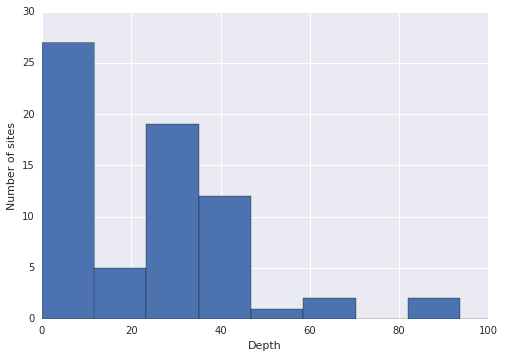

In [16]:
df = pd.read_table(outfile, names=['chrom','position','depth'])
print("number of sites with coverage greater than 100: {}".format(df[df['depth']>100].shape[0]))
print("number of sites with coverage less than 5: {}".format(df[df['depth']<5].shape[0]))

ax = df['depth'].hist(bins=300)
ax.set_xlim(0,100)
ax.set_xlabel('Depth')
ax.set_ylabel('Number of sites')


# Re-do the coverage counts with filtered bam (34 sites have less than 5 reads)
- This is basically the set of reads that we call 'True': filtered for potential sequencing defects and PCR-duplicate removed (via coordinates... no UMIs used in this library). We have justified why we include the PCR-duplicate removal step in the manuscript?

In [17]:
bam = os.path.join(editing_calls_dir, 'WT.sorted.rmdup.readfiltered.bam')
outfile = os.path.join(wd,'depth.rmdup.readfiltered.txt')
cmd = 'samtools depth '
cmd = cmd + '-b {} '.format(notfound_bed)
cmd = cmd + '{} '.format(bam) # bam is the original combined WT bam
cmd = cmd + '> {}'.format(outfile)
! $cmd

number of sites with coverage greater than 100: 0
number of sites with coverage less than 5: 34


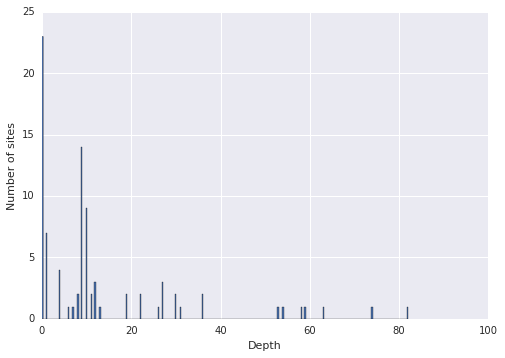

In [18]:
df = pd.read_table(outfile, names=['chrom','position','depth'])
print("number of sites with coverage greater than 100: {}".format(df[df['depth']>100].shape[0]))
print("number of sites with coverage less than 5: {}".format(df[df['depth']<5].shape[0]))

ax = df['depth'].hist(bins=300)
ax.set_xlim(0,100)
ax.set_xlabel('Depth')
ax.set_ylabel('Number of sites')


# Of the sites with sufficient coverage, how many just miss conf cutoff? (30 sites missed cutoffs, 20 sites have score of over 90%)
- 30 sites had a confidence score, which means that it was an editing candidate. Of these:
    - (1) site had a zero confidence score because it was 100% edited and was called as a possible snp
    - 20 sites had a confidence score above 90%

Number of sites that did not meet our cutoffs: 30
Number of sites that have greater than 90% confidence: 20


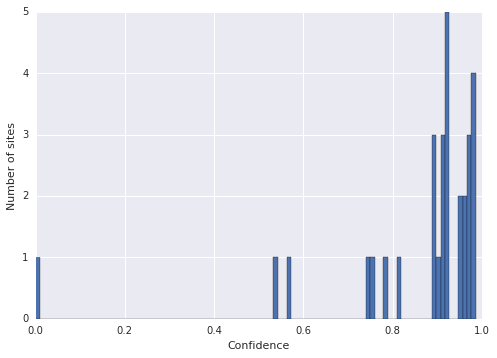

In [19]:
# format the bedfile
out_filtered_bed = os.path.join(wd,'filtered.bed')
fwd_bed = os.path.join(
    editing_calls_dir, 'WT.fwd.sorted.rmdup.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed'
)
rev_bed = os.path.join(
    editing_calls_dir, 'WT.rev.sorted.rmdup.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed'
)

fwd = pd.read_table(fwd_bed, names=['chrom','start','end','name','score','strand'])
rev = pd.read_table(rev_bed, names=['chrom','start','end','name','score','strand'])

bed = pd.concat([fwd, rev])

df_sufficient_coverage = df[df['depth']>=5]
lowly_scored = pd.merge(
    df_sufficient_coverage, bed, how='left', 
    left_on=['chrom','position'], right_on=['chrom','end']
)
lowly_scored_90 = lowly_scored[lowly_scored['score']>0.9]
print("Number of sites that did not meet our cutoffs: {}".format(lowly_scored.dropna().shape[0]))
print("Number of sites that have greater than 90% confidence: {}".format(lowly_scored_90.shape[0]))
ax = lowly_scored.dropna()['score'].hist(bins=100)
ax.set_xlabel('Confidence')
ax.set_ylabel('Number of sites')

# Of the 10 that did not have a score of over 90, 9 reported editing at less than 10%, 1 reported editing at 100% (could be a SNP)

In [20]:
lowly_scored.dropna()[lowly_scored.dropna()['score']<0.9]

,chrom,position,depth,start,end,name,score,strand
1,chrI,2033893,59,2033892.0,2033893.0,58|A>G|0.034482759,0.888578,+
2,chrI,2033894,58,2033893.0,2033894.0,57|A>G|0.01754386,0.569601,+
3,chrI,2034071,30,2034070.0,2034071.0,30|A>G|0.033333333,0.747172,+
23,chrIII,3028198,9,3028197.0,3028198.0,9|T>C|1.0,0.000000,-
26,chrIII,3028445,12,3028444.0,3028445.0,12|T>C|0.083333333,0.895338,-
33,chrIII,6701729,26,6701728.0,6701729.0,25|A>G|0.04,0.785678,+
34,chrIII,6701761,30,6701760.0,6701761.0,29|A>G|0.034482759,0.754719,+
42,chrV,9556359,63,9556358.0,9556359.0,63|T>C|0.015873016,0.536268,-
49,chrV,13135916,22,13135915.0,13135916.0,22|T>C|0.045454545,0.809728,-
52,chrX,16224184,12,16224183.0,16224184.0,12|A>G|0.083333333,0.895338,+


# The rest do not have confidence scores, so either did not see any variants or something else (23 sites did not contain variants of 'high quality' - specified by the DP4 field in the VCF file produced by samtools mpileup)
- 34 don't have coverage after read filtering
- 30 don't have sufficient confidence score 
- 23 don't have variant info

In [21]:
potential_nonvariants = lowly_scored[pd.isnull(lowly_scored).any(axis=1)][['chrom','position']]
print("number of positions potentially non variants", potential_nonvariants.shape)
potential_nonvariants.head()

('number of positions potentially non variants', (23, 2))


,chrom,position
6,chrIII,3028098
7,chrIII,3028125
8,chrIII,3028130
9,chrIII,3028141
10,chrIII,3028147


In [22]:
vcf_fwd = pd.read_table(
    os.path.join(editing_calls_dir, 'WT.fwd.sorted.rmdup.readfiltered.formatted.vcf'), 
    comment='#',
    names=['chrom','position','id','ref','alt','qual','filter','info','format','baz']
)
vcf_rev = pd.read_table(
    os.path.join(editing_calls_dir, 'WT.rev.sorted.rmdup.readfiltered.formatted.vcf'), 
    comment='#',
    names=['chrom','position','id','ref','alt','qual','filter','info','format','baz']
)
vcf_fwd['dp4'] = vcf_fwd['info'].str.extract("DP4=([\d,]+);")
vcf_rev['dp4'] = vcf_rev['info'].str.extract("DP4=([\d,]+);")

vcf = pd.concat([vcf_fwd, vcf_rev])
vcf.head()

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  # This is added back by InteractiveShellApp.init_path()
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if sys.path[0] == '':


,chrom,position,id,ref,alt,qual,filter,info,format,baz,dp4
0,chrI,9229,.,A,G,4.6171,.,"DP=2;DPR=0,2;VDB=0.06;SGB=-0.453602;MQ0F=0;AF1...",GT:PL:DP:DV:SP:DP4:DPR,"0/0:36,6,0:2:2:0:0,0,0,2:0,2","0,0,0,2"
1,chrI,9461,.,A,G,17.6055,.,"DP=1;DPR=0,1;SGB=-0.379885;MQ0F=0;AF1=1;AC1=2;...",GT:PL:DP:DV:SP:DP4:DPR,"0/0:20,3,0:1:1:0:0,0,0,1:0,1","0,0,0,1"
2,chrI,9510,.,C,T,17.6055,.,"DP=1;DPR=0,1;SGB=-0.379885;MQ0F=0;AF1=1;AC1=2;...",GT:PL:DP:DV:SP:DP4:DPR,"0/0:20,3,0:1:1:0:0,0,0,1:0,1","0,0,0,1"
3,chrI,11643,.,G,T,140.5470,.,"DP=111;DPR=110,1;SGB=-0.379885;RPB=1;MQB=1;BQB...",GT:PL:DP:DV:SP:DP4:DPR,"0/0:0,255,100:111:1:0:0,110,0,1:110,1","0,110,0,1"
4,chrI,11689,.,G,A,139.5460,.,"DP=110;DPR=109,1;SGB=-0.379885;RPB=1;MQB=1;BQB...",GT:PL:DP:DV:SP:DP4:DPR,"0/0:0,255,99:110:1:0:0,109,0,1:109,1","0,109,0,1"


In [23]:
# intersection between variants found and positions yields empty dataframe
pd.merge(potential_nonvariants, vcf, how='left', on=['chrom','position']).dropna()

,chrom,position,id,ref,alt,qual,filter,info,format,baz,dp4


# Of the 87 uncalled sites: 34 did not have sufficient coverage, 30 did not have a high enough score, 23 did not see variants

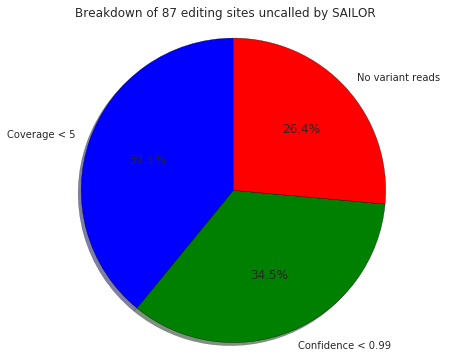

In [24]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Coverage < 5','Confidence < 0.99','No variant reads']
sizes = [34,30,23]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.suptitle("Breakdown of 87 editing sites uncalled by SAILOR")
plt.show()